# Open source Map

In [19]:
from bs4 import BeautifulSoup

In [20]:
with open("map.osm", "r", encoding="utf8") as file:
    content = file.read()

In [21]:
soup = BeautifulSoup(content)

In [22]:
[tag for tag in soup.find("way").children]

['\n',
 <nd ref="65662877"></nd>,
 '\n',
 <nd ref="6045359840"></nd>,
 '\n',
 <nd ref="65662878"></nd>,
 '\n',
 <nd ref="6045359839"></nd>,
 '\n',
 <nd ref="65662880"></nd>,
 '\n',
 <nd ref="6045359841"></nd>,
 '\n',
 <nd ref="65662882"></nd>,
 '\n',
 <nd ref="65662883"></nd>,
 '\n',
 <tag k="highway" v="residential"></tag>,
 '\n',
 <tag k="name" v="Schneider Drive"></tag>,
 '\n',
 <tag k="tiger:cfcc" v="A41"></tag>,
 '\n',
 <tag k="tiger:county" v="Juneau, AK"></tag>,
 '\n',
 <tag k="tiger:name_base" v="Schneider"></tag>,
 '\n',
 <tag k="tiger:name_type" v="Dr"></tag>,
 '\n',
 <tag k="tiger:reviewed" v="no"></tag>,
 '\n']

In [23]:
from dataclasses import dataclass

In [24]:
@dataclass
class Node:
    id: int
    lat: float
    lon: float

In [25]:
from typing import Dict, List, Any, Optional, Tuple

nodes: Dict[int, Node] = dict()
for node in soup.find_all("node"):
    attrs = node.attrs
    node_id = int(attrs['id'])
    lat = float(attrs['lat'])
    lon = float(attrs['lon'])
    nodes[node_id] = Node(node_id, lat, lon)

In [26]:
import tripy
from dataclasses import field
from functional import seq

@dataclass(unsafe_hash=True)
class Building:
    id: int = field(compare=True) 
    nodes: List[Node] = field(compare=False) 
    tags: Dict[str, Any] = field(compare=False) 

    def triangulate(self) -> List[Tuple[Tuple[float, float]]]:
        return tripy.earclip(
            seq(self.nodes)
                .map(lambda x: (x.lon, x.lat))
                .take(len(self.nodes) - 1)
                .list()
            )
    
    def get_centroid(self) -> Tuple[float, float]:
        triangles = self.triangulate()
        total_area = 0
        centroid_x = 0
        centroid_y = 0

        for triangle in triangles:
            p1, p2, p3 = triangle
            
            # Calculate the centroid of the triangle
            tri_centroid_x = (p1[0] + p2[0] + p3[0]) / 3
            tri_centroid_y = (p1[1] + p2[1] + p3[1]) / 3

            # Calculate the area of the triangle
            tri_area = self._triangle_area(p1, p2, p3)

            # Accumulate weighted centroids
            centroid_x += tri_centroid_x * tri_area
            centroid_y += tri_centroid_y * tri_area
            total_area += tri_area

        # Final centroid is the weighted average of all triangle centroids
        if total_area == 0:
            raise ValueError("The building's area is zero. Centroid cannot be calculated.")

        return centroid_x / total_area, centroid_y / total_area
    
    def contains(self, lon: float, lat: float) -> bool:# Get the triangles from the triangulate method
        triangles = self.triangulate()

        for triangle in triangles:
            if self._point_in_triangle((lon, lat), triangle):
                return True
        return False

    @staticmethod
    def _triangle_area(p1: Tuple[float, float], p2: Tuple[float, float], p3: Tuple[float, float]) -> float:
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3
        return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2)

    @staticmethod
    def _point_in_triangle(point: Tuple[float, float], triangle: Tuple[Tuple[float, float]]):
        p1, p2, p3 = triangle
        
        total_area = Building._triangle_area(p1, p2, p3)

        area1 = Building._triangle_area(point, p2, p3)
        area2 = Building._triangle_area(p1, point, p3)
        area3 = Building._triangle_area(p1, p2, point)

        return abs(total_area - (area1 + area2 + area3)) < 1e-9

In [27]:
@dataclass
class Road:
    id: int
    nodes: List[Node]
    tags: Dict[str, Any]

In [28]:
houses = []
roads = []

for way in soup.find_all("way"):
    node_ref = []
    tags = set()
    
    way_type = ""

    way_id = way.attrs["id"]

    for tag in way.children:
        if tag == "\n":
            continue

        attrs = tag.attrs
        match tag.name:
            case "nd":
                node_ref.append(attrs["ref"])
            case "tag":
                match attrs["k"]:
                    case "highway":
                        way_type = "highway"
                    case "building":
                        way_type = "building"
                    case _:
                        tags.add((attrs["k"],attrs["v"]))
    
    match way_type:
        case "highway":
            roads.append(Road(
                way_id,
                seq(node_ref).map(int).map(nodes.get).list(),
                dict(tags)
            ))
        case "building":
            houses.append(Building(
                way_id,
                seq(node_ref).map(int).map(nodes.get).list(),
                dict(tags)
            ))
roads
# print(tags)

[Road(id='8966534', nodes=[Node(id=65662877, lat=58.3614442, lon=-134.5154038), Node(id=6045359840, lat=58.361365, lon=-134.5154879), Node(id=65662878, lat=58.3612941, lon=-134.5155917), Node(id=6045359839, lat=58.3612389, lon=-134.5157132), Node(id=65662880, lat=58.3612106, lon=-134.5159078), Node(id=6045359841, lat=58.3611978, lon=-134.5162327), Node(id=65662882, lat=58.3611788, lon=-134.5165755), Node(id=65662883, lat=58.3611175, lon=-134.5172957)], tags={'name': 'Schneider Drive', 'tiger:reviewed': 'no', 'tiger:name_type': 'Dr', 'tiger:cfcc': 'A41', 'tiger:name_base': 'Schneider', 'tiger:county': 'Juneau, AK'}),
 Road(id='8966574', nodes=[Node(id=65663110, lat=58.3614183, lon=-134.4904655), Node(id=65663112, lat=58.3620428, lon=-134.4928043)], tags={'tiger:cfcc': 'A41', 'tiger:county': 'Juneau, AK'}),
 Road(id='8966581', nodes=[Node(id=65662882, lat=58.3611788, lon=-134.5165755), Node(id=65663140, lat=58.3613619, lon=-134.5166295)], tags={'tiger:reviewed': 'no', 'tiger:name_type': 

In [29]:
houses[2]

Building(id='344350881', nodes=[Node(id=3511016987, lat=58.3626027, lon=-134.5158775), Node(id=3511016988, lat=58.3626366, lon=-134.5153861), Node(id=3511016989, lat=58.3627979, lon=-134.5154265), Node(id=3511016990, lat=58.3628469, lon=-134.5147162), Node(id=3511016991, lat=58.3627632, lon=-134.5146953), Node(id=3511016992, lat=58.3627933, lon=-134.514258), Node(id=3511017993, lat=58.3628769, lon=-134.5142789), Node(id=3511017994, lat=58.362933, lon=-134.5134638), Node(id=3511017995, lat=58.3631695, lon=-134.513523), Node(id=3511017996, lat=58.3631213, lon=-134.5142218), Node(id=3511017997, lat=58.3633385, lon=-134.5142762), Node(id=3511017998, lat=58.3632928, lon=-134.5149402), Node(id=3511017999, lat=58.3631073, lon=-134.5148937), Node(id=3511018000, lat=58.3630321, lon=-134.5159851), Node(id=3511016987, lat=58.3626027, lon=-134.5158775)], tags={'name': "Dzantik'i Heeni Middle School"})

[((-134.4938943, 58.3624955), (-134.493901, 58.3623285), (-134.4937293, 58.3623266)), ((-134.4938943, 58.3624955), (-134.4937293, 58.3623266), (-134.4937225, 58.3624936))]
2
Building(id='450917530', nodes=[Node(id=4478162534, lat=58.3624955, lon=-134.4938943), Node(id=4478162535, lat=58.3624936, lon=-134.4937225), Node(id=4478162536, lat=58.3623266, lon=-134.4937293), Node(id=4478162537, lat=58.3623285, lon=-134.493901), Node(id=4478162534, lat=58.3624955, lon=-134.4938943)], tags={})
(-134.4938117745779, 58.36241105809819)


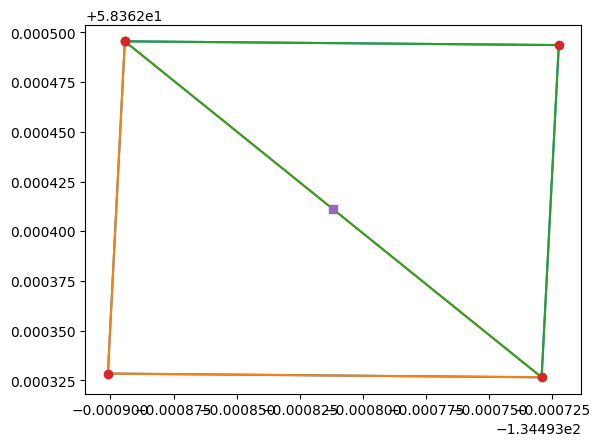

True

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 

house = houses[56]


tri = house.triangulate()

center =  house.get_centroid()

print(tri)
print(len(tri))


print(house)
print(center)



plt.plot(seq(house.nodes).map(lambda x: x.lon).list(), seq(house.nodes).map(lambda x: x.lat).list())

for (x, y, z) in tri:
    plt.plot([x[0], y[0], z[0], x[0]], [x[1], y[1], z[1], x[1]])
# plt.triplot(
#     seq(houses[0].nodes).map(lambda x: x.lon).list(),
#     seq(houses[0].nodes).map(lambda x: x.lat).list(),
#     tri.simplices.copy()
# ) 
plt.plot(seq(house.nodes).map(lambda x: x.lon).list(), seq(house.nodes).map(lambda x: x.lat).list(), 'o') 

plt.plot([center[0]], [center[1]], 's')

plt.show()

house.contains(*center)

In [31]:
import networkx as nx

In [32]:
def check_intersection(p1: Node, p2: Node, q1: Node, q2: Node) -> Optional[Tuple[float, float]]:
    """
    Check if line segments (p1, p2) and (q1, q2) intersect.
    If they do, return the intersection point (lat, lon).
    """
    def orientation(a, b, c):
        # Calculate the orientation of the triplet (a, b, c)
        return (b.lon - a.lon) * (c.lat - a.lat) - (b.lat - a.lat) * (c.lon - a.lon)

    def on_segment(a, b, c):
        # Check if point c lies on segment (a, b)
        return (
            min(a.lat, b.lat) <= c.lat <= max(a.lat, b.lat) and
            min(a.lon, b.lon) <= c.lon <= max(a.lon, b.lon)
        )

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    if o1 * o2 < 0 and o3 * o4 < 0:
        # Line segments intersect, calculate intersection point
        a1, b1, c1 = p2.lat - p1.lat, p1.lon - p2.lon, p2.lon * p1.lat - p1.lon * p2.lat
        a2, b2, c2 = q2.lat - q1.lat, q1.lon - q2.lon, q2.lon * q1.lat - q1.lon * q2.lat
        det = a1 * b2 - a2 * b1
        if det == 0:
            return None  # Lines are parallel
        lat = (b1 * c2 - b2 * c1) / det
        lon = (c1 * a2 - c2 * a1) / det
        return (lat, lon)

    return None

def find_nearby_node(G: nx.Graph, lat: float, lon: float, threshold: float = 1e-6) -> Optional[int]:
    """
    Check if there is an existing node in the graph near the given lat, lon.
    If a nearby node exists within the threshold, return its ID.
    """
    for node_id, data in G.nodes(data=True):
        if abs(data['lat'] - lat) <= threshold and abs(data['lon'] - lon) <= threshold:
            return node_id
    return None

def merge_roads(roads: List[Road], node_id_counter: int) -> nx.Graph:
    """
    Check for intersections among all roads, add new nodes where intersections are found,
    and convert the roads into a NetworkX graph.
    Returns the resulting graph.
    """
    G = nx.Graph()

    for road in roads:
        for i in range(len(road.nodes) - 1):
            node1 = road.nodes[i]
            node2 = road.nodes[i + 1]
            G.add_node(node1.id, lat=node1.lat, lon=node1.lon)
            G.add_node(node2.id, lat=node2.lat, lon=node2.lon)
            G.add_edge(node1.id, node2.id, road_id=road.id)

    for i in range(len(roads)):
        for j in range(i + 1, len(roads)):
            road1 = roads[i]
            road2 = roads[j]
            for k in range(len(road1.nodes) - 1):
                for l in range(len(road2.nodes) - 1):
                    intersection = check_intersection(road1.nodes[k], road1.nodes[k + 1], road2.nodes[l], road2.nodes[l + 1])
                    if intersection:
                        lat, lon = intersection

                        # Check if a nearby node already exists
                        existing_node_id = find_nearby_node(G, lat, lon)
                        if existing_node_id is not None:
                            new_node_id = existing_node_id
                        else:
                            new_node_id = node_id_counter
                            G.add_node(new_node_id, lat=lat, lon=lon)
                            node_id_counter += 1

                        # Add the intersection node to the roads
                        road1.nodes.insert(k + 1, Node(id=new_node_id, lat=lat, lon=lon))
                        road2.nodes.insert(l + 1, Node(id=new_node_id, lat=lat, lon=lon))

    return G

# Graph stuff

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

In [34]:

def plot_scatter_graph(buildings: List[List[Building]], road_graph: nx.Graph, path: Optional[List[int]] = None, points_of_interest: Optional[List[Node]] = None):
    """
    Plots a scatter graph using the lat and lon of the nodes in the buildings and roads.
    Draws lines between nodes to outline the buildings and roads. Optionally, renders a path.

    :param buildings: List of Building objects
    :param road_graph: A networkx Graph object representing roads
    :param path: An optional list of node IDs representing the path to be rendered on the road graph
    """
    plt.figure(figsize=(10, 8))

    # Plot buildings
    for b1 in buildings:
        colors = list(mcolors.TABLEAU_COLORS.values())  # Use a predefined color palette
        road_color = random.choice(colors)
        for b2 in b1:
            # print(b2)
            # Extract latitudes and longitudes for the building
            lats = [node.lat for node in b2.nodes]
            lons = [node.lon for node in b2.nodes]
            # Close the outline by appending the first node at the end
            if len(b2.nodes) > 1:
                lats.append(b2.nodes[0].lat)
                lons.append(b2.nodes[0].lon)

            # Draw lines between nodes to outline the building
            
            plt.plot(lons, lats, c=road_color, label=f'Building {b2.id} Outline', linewidth=0.25)

    # Plot roads from the networkx graph
    colors = list(mcolors.TABLEAU_COLORS.values())  # Use a predefined color palette
    road_color = random.choice(colors)

    for edge in road_graph.edges:
        # Extract the nodes from the edge
        node1, node2 = edge
        lat1, lon1 = road_graph.nodes[node1]['lat'], road_graph.nodes[node1]['lon']
        lat2, lon2 = road_graph.nodes[node2]['lat'], road_graph.nodes[node2]['lon']

        # Draw the road as a line between the two nodes
        plt.plot([lon1, lon2], [lat1, lat2], c=road_color, linestyle='--', label='Road', linewidth=0.25)

    # Render path if provided
    if path is not None and len(path) > 1:
        path_lats = []
        path_lons = []
        for node_id in path:
            lat, lon = road_graph.nodes[node_id]['lat'], road_graph.nodes[node_id]['lon']
            path_lats.append(lat)
            path_lons.append(lon)

        # Plot the path as a solid line
        plt.plot(path_lons, path_lats, c='green', linestyle='-', linewidth=2, label='Path')

    if points_of_interest is not None and len(points_of_interest) > 1:
        lats = [node.lat for node in points_of_interest]
        lons = [node.lon for node in points_of_interest]
        # labels = ["" if node.get("name") is None else node.get("name") for node in points_of_interest]

        plt.scatter(lons, lats,s=0.1)

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Scatter Plot of Buildings and Roads with Outlines')
    plt.grid(True)
    plt.savefig("plot.svg", format="svg")
    plt.show()

In [35]:
graph = merge_roads(roads, seq(nodes.items()).map(lambda x: x[1]).map(lambda x: x.id).max()+1)

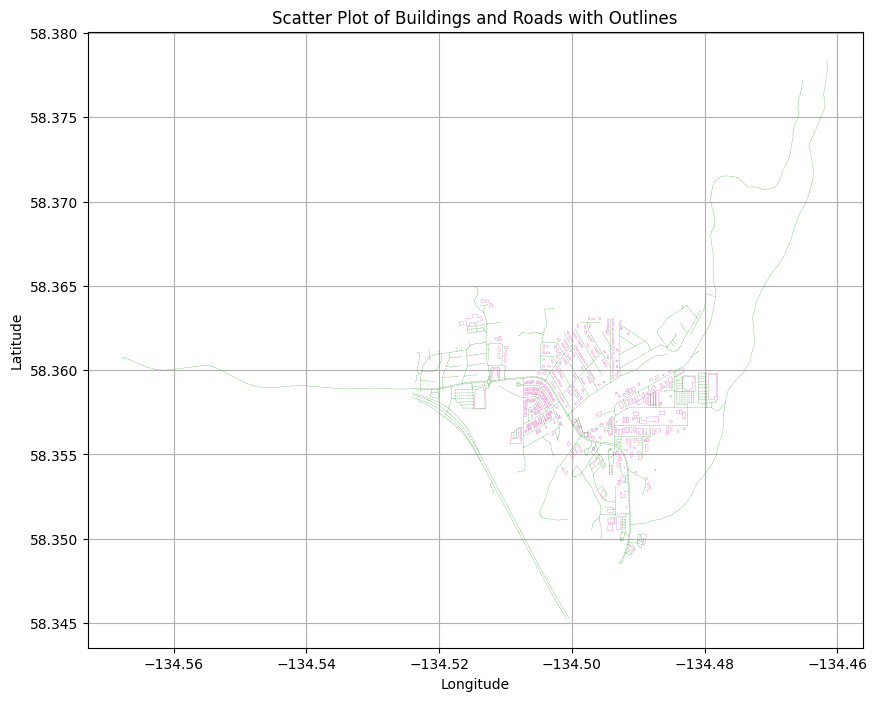

In [37]:
plot_scatter_graph([houses], graph)

In [38]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the Haversine distance between two points on the Earth.
    Returns the distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Radius of Earth in kilometers (use 6371 for km or 3958.8 for miles)
    radius = 6371.0
    distance = radius * c
    return distance

def find_shortest_path(G: nx.Graph, start_node_id: int, end_node_id: int) -> List[int]:
    """
    Finds the shortest path between two nodes in the graph based on Haversine distance.
    Returns the list of node IDs representing the shortest path from start_node_id to end_node_id.
    """
    # Define a custom weight function for the edges based on Haversine distance
    def haversine_weight(u, v, data):
        lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
        lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
        return haversine(lat1, lon1, lat2, lon2)
    
    try:
        # Using Dijkstra's algorithm with Haversine distance as weight
        shortest_path = nx.dijkstra_path(G, source=start_node_id, target=end_node_id, weight=haversine_weight)
        return shortest_path
    except nx.NetworkXNoPath:
        print(f"No path found between node {start_node_id} and node {end_node_id}.")
        return []

In [39]:
# Example Usage
start_node_id = roads[3].nodes[0].id  # Starting node ID
end_node_id = roads[32].nodes[0].id    # Ending node ID

shortest_path = find_shortest_path(graph, start_node_id, end_node_id)

In [40]:
(start_node_id, end_node_id)

(65664834, 65666063)

In [41]:
shortest_path

[65664834,
 12465171825,
 6040636890,
 11381378825,
 11381378826,
 11381378827,
 11381378828,
 11381378829,
 11381378830,
 12465171821,
 11381378831,
 11381378832,
 11381378833,
 11381378834,
 11381378782,
 11381378781,
 11381378780,
 11381378779,
 11381378778,
 11381378777,
 11381378786,
 11381378776,
 12465171819,
 11381378784,
 11381378775,
 11381378774,
 11381378796,
 11381378769,
 11381378794,
 11381378793,
 11381378792,
 11381378791,
 11381378790,
 1969248339,
 6045007598,
 6045007600,
 65675248,
 6045007599,
 65673060,
 564216502,
 12060614437,
 12060614438,
 11339457120,
 11339457121,
 11339457122,
 12060614447,
 11339457123,
 11339457124,
 11339457125,
 11339457126,
 65662334,
 6045327430,
 6045327428,
 6045327429,
 65675617,
 65675614,
 65675612,
 65672408,
 65672404,
 65672402,
 65666063]

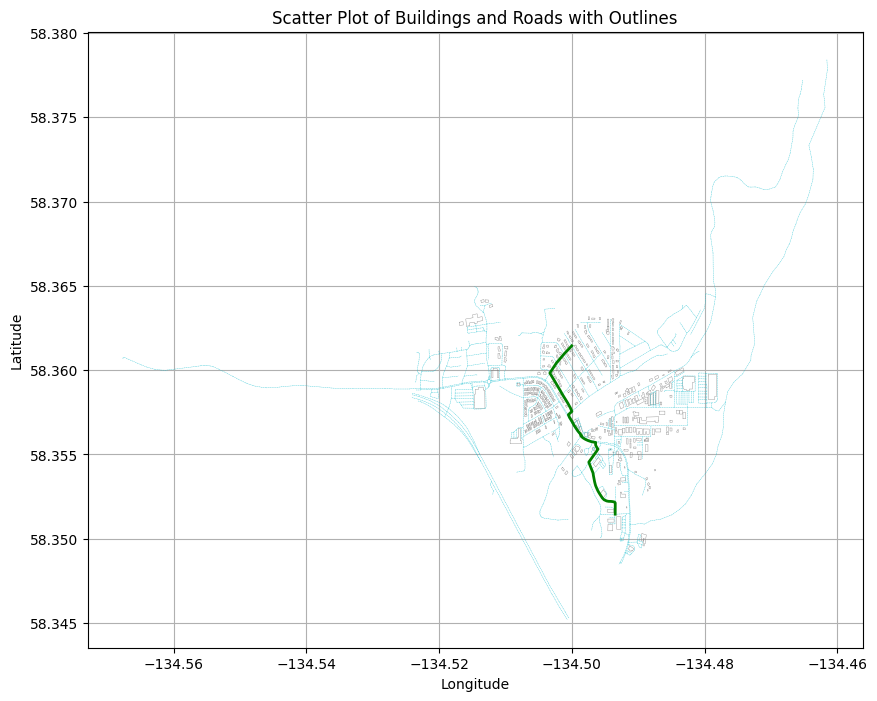

In [43]:
plot_scatter_graph([houses], graph, shortest_path)

In [44]:
houses

[Building(id='44369015', nodes=[Node(id=563889819, lat=58.3565403, lon=-134.507998), Node(id=563889822, lat=58.3560268, lon=-134.5079957), Node(id=563889823, lat=58.3560265, lon=-134.508194), Node(id=563889825, lat=58.3559333, lon=-134.5081937), Node(id=563889826, lat=58.3559322, lon=-134.5092251), Node(id=563889829, lat=58.355842, lon=-134.5092248), Node(id=563889833, lat=58.3558419, lon=-134.5093017), Node(id=563889835, lat=58.3556294, lon=-134.5093011), Node(id=563889836, lat=58.3556307, lon=-134.5075688), Node(id=563889838, lat=58.3558041, lon=-134.5075692), Node(id=563889841, lat=58.3558039, lon=-134.5077753), Node(id=563889847, lat=58.3565405, lon=-134.5077791), Node(id=563889819, lat=58.3565403, lon=-134.507998)], tags={'amenity': 'police', 'name': 'Juneau Police Department'}),
 Building(id='341055978', nodes=[Node(id=3482832484, lat=58.3596151, lon=-134.4831533), Node(id=3482832485, lat=58.3596186, lon=-134.4815522), Node(id=3482832486, lat=58.3592749, lon=-134.4815494), Node(i

# Google API

In [45]:
import requests
import os

In [52]:
from pathlib import Path

from dotenv import load_dotenv
import os

load_dotenv()

True

In [53]:
def get_data(lat: float, lon: float, range: float, type: Optional[str] = None):
    API_KEY = os.environ["X-GOOG-API-KEY"]

    location_type = "" if type is None else f"&type={type}"

    response = requests.post(
        f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={lat}%2C{lon}&radius={range}&key={API_KEY}{location_type}"
    )

    status= response.json().get("status")

    match status:
        case "OK":
            return (seq(response.json().get("results"))
                .map(lambda place: (place["geometry"]["location"]["lat"],place["geometry"]["location"]["lng"], place["name"]))
                .map(lambda place: (Node(None, place[0], place[1]), place[2]))
                .list()
            )
        case "ZERO_RESULTS":
            return []

In [54]:
bounds = soup.find("bounds")

min_lat = float(bounds.attrs["minlat"])
max_lat = float(bounds.attrs["maxlat"])

min_lon = float(bounds.attrs["minlon"])
max_lon = float(bounds.attrs["maxlon"])

lat_delta = (min_lat-min_lat)
lon_delta = (max_lon-min_lon)

lat = lat_delta/2.+min_lat
lon = lon_delta/2.+min_lon

# Earth's radius in meters
earth_radius_m = 6371000.0

# Convert deltas to radians
lat_delta_rad = radians(lat_delta)
lon_delta_rad = radians(lon_delta)

# Approximate the radius in meters
radius = earth_radius_m * sqrt(lat_delta_rad**2 + (lon_delta_rad * cos(radians(lat)))**2)

(lat, lon, radius)

(58.34854, -134.500185, 2676.4967144178895)

In [55]:
location_types = [
    "accounting",
    "airport",
    "amusement_park",
    "aquarium",
    "art_gallery",
    "atm",
    "bakery",
    "bank",
    "bar",
    "beauty_salon",
    "bicycle_store",
    "book_store",
    "bowling_alley",
    "bus_station",
    "cafe",
    "campground",
    "car_dealer",
    "car_rental",
    "car_repair",
    "car_wash",
    "casino",
    "cemetery",
    "church",
    "city_hall",
    "clothing_store",
    "convenience_store",
    "courthouse",
    "dentist",
    "department_store",
    "doctor",
    "drugstore",
    "electrician",
    "electronics_store",
    "embassy",
    "fire_station",
    "florist",
    "funeral_home",
    "furniture_store",
    "gas_station",
    "gym",
    "hair_care",
    "hardware_store",
    "hindu_temple",
    "home_goods_store",
    "hospital",
    "insurance_agency",
    "jewelry_store",
    "laundry",
    "lawyer",
    "library",
    "light_rail_station",
    "liquor_store",
    "local_government_office",
    "locksmith",
    "lodging",
    "meal_delivery",
    "meal_takeaway",
    "mosque",
    "movie_rental",
    "movie_theater",
    "moving_company",
    "museum",
    "night_club",
    "painter",
    "park",
    "parking",
    "pet_store",
    "pharmacy",
    "physiotherapist",
    "plumber",
    "police",
    "post_office",
    "primary_school",
    "real_estate_agency",
    "restaurant",
    "roofing_contractor",
    "rv_park",
    "school",
    "secondary_school",
    "shoe_store",
    "shopping_mall",
    "spa",
    "stadium",
    "storage",
    "store",
    "subway_station",
    "supermarket",
    "synagogue",
    "taxi_stand",
    "tourist_attraction",
    "train_station",
    "transit_station",
    "travel_agency",
    "university",
    "veterinary_care",
    "zoo"
]

In [56]:
points_of_interest = []

delta_lat_meters = 1000  # Step size in meters for latitude
delta_lon_meters = 1000  # Step size in meters for longitude

meters_per_degree_lat = 111320  # Approximate length of one degree latitude in meters
delta_lat = delta_lat_meters / meters_per_degree_lat

# Function to calculate meters per degree longitude
def meters_per_degree_lon(lat):
    return 111320 * cos(radians(lat))

locations_by_type = dict()

for location_type in location_types:
    # print(location_type)
    locations = dict()

    # Traverse the grid
    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        delta_lon = delta_lon_meters / meters_per_degree_lon(lat)
        while lon <= max_lon:
            radius = (delta_lat_meters ** 2 + delta_lon_meters ** 2) ** 0.5

            tmp_lat = lat + delta_lat / 2.
            tmp_lon = lon + delta_lon / 2.
            
            for node, name in get_data(lat, lon, radius):
                locations[name] = (node, name)

            
            # print(f"Latitude: {lat}, Longitude: {lon}:\n{get_data(lat, lon, radius)}")
            lon += delta_lon
        lat += delta_lat

    locations_by_type[location_type] = (
        seq(locations.items())
        .map(lambda x: x[1])
        # .peek(lambda x: print(f"{min_lat} <= {x[0].lat} <= {max_lat} and {min_lon} <= {x[0].lon} <= {max_lon}"))
        # .peek(lambda x: print(f"{min_lat <= x[0].lat <= max_lat} and {min_lon <= x[0].lon <= max_lon}"))
        .filter(lambda x: (min_lat <= x[0].lat <= max_lat) and (min_lon <= x[0].lon <= max_lon))
        .list()
    )
# seq(range(min_lat, max_lon, )) get_data(lat, lon, radius, type=location_types[0])

locations_by_type

{'accounting': [(Node(id=None, lat=58.3604463, lon=-134.5187339),
   'JoAnn Everson Independent Princess House Consultant'),
  (Node(id=None, lat=58.35389379999999, lon=-134.5021964), 'Aggpro'),
  (Node(id=None, lat=58.35584059999999, lon=-134.5080385),
   'Juneau Police Department'),
  (Node(id=None, lat=58.3529511, lon=-134.5118688),
   'Mendenhall Wetlands Scenic View Turnout'),
  (Node(id=None, lat=58.35709999999999, lon=-134.512), 'Duran Trucking'),
  (Node(id=None, lat=58.3582067, lon=-134.5146917),
   'Trailer Rental at U-Haul'),
  (Node(id=None, lat=58.3582067, lon=-134.5146917),
   'Moving Supplies at U-Haul'),
  (Node(id=None, lat=58.3582067, lon=-134.5146917), 'U-Box at U-Haul'),
  (Node(id=None, lat=58.3582067, lon=-134.5146917),
   'U-Haul Moving & Storage of Lemon Creek Juneau'),
  (Node(id=None, lat=58.3554641, lon=-134.5074183), 'Kingfisher Loop Trail'),
  (Node(id=None, lat=58.35584059999999, lon=-134.5080385),
   'State Troopers-Drug Invstgtn'),
  (Node(id=None, lat=5

In [57]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# MODEL_DIR: Path = Path(os.environ['MODEL_DIR'])
# os.environ['TRANSFORMERS_CACHE'] = f"{MODEL_DIR}"
# os.environ['HF_HOME'] = f"{MODEL_DIR}"

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# print(device)

# model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# premise = f"location: Budget Car Rental"
# hypothesis = "This building is an airport?"

# input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
# output = model(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
# prediction = torch.softmax(output["logits"][0], -1).tolist()
# label_names = ["yes", "no"]
# prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
# print(prediction)

In [58]:
locations_by_type["airport"]

[(Node(id=None, lat=58.3604463, lon=-134.5187339),
  'JoAnn Everson Independent Princess House Consultant'),
 (Node(id=None, lat=58.35389379999999, lon=-134.5021964), 'Aggpro'),
 (Node(id=None, lat=58.35584059999999, lon=-134.5080385),
  'Juneau Police Department'),
 (Node(id=None, lat=58.3529511, lon=-134.5118688),
  'Mendenhall Wetlands Scenic View Turnout'),
 (Node(id=None, lat=58.35709999999999, lon=-134.512), 'Duran Trucking'),
 (Node(id=None, lat=58.3582067, lon=-134.5146917), 'Trailer Rental at U-Haul'),
 (Node(id=None, lat=58.3582067, lon=-134.5146917),
  'Moving Supplies at U-Haul'),
 (Node(id=None, lat=58.3582067, lon=-134.5146917), 'U-Box at U-Haul'),
 (Node(id=None, lat=58.3582067, lon=-134.5146917),
  'U-Haul Moving & Storage of Lemon Creek Juneau'),
 (Node(id=None, lat=58.3554641, lon=-134.5074183), 'Kingfisher Loop Trail'),
 (Node(id=None, lat=58.35584059999999, lon=-134.5080385),
  'State Troopers-Drug Invstgtn'),
 (Node(id=None, lat=58.35531330000001, lon=-134.4992054)

In [59]:
from functional import pseq
building_by_type = (seq(locations_by_type.items())
    .map(lambda x: (
        x[0],
        seq(x[1])
            .map(lambda x: x[0])
            # .peek(print)
            .map(lambda node: seq(houses)
                    # .peek(print)
                    .map(lambda house: house if house.contains(node.lon, node.lat) else None)
                    # .peek(print)
                    .filter(lambda house: house is not None)
                    .list()
            )
            # .peek(print)
            .map(lambda candidates: candidates[0] if len(candidates) > 0 else None)
            .filter(lambda x: x is not None)
            .list(),
        
    ))
    .dict()
)

building_by_type["airport"]

[Building(id='44369015', nodes=[Node(id=563889819, lat=58.3565403, lon=-134.507998), Node(id=563889822, lat=58.3560268, lon=-134.5079957), Node(id=563889823, lat=58.3560265, lon=-134.508194), Node(id=563889825, lat=58.3559333, lon=-134.5081937), Node(id=563889826, lat=58.3559322, lon=-134.5092251), Node(id=563889829, lat=58.355842, lon=-134.5092248), Node(id=563889833, lat=58.3558419, lon=-134.5093017), Node(id=563889835, lat=58.3556294, lon=-134.5093011), Node(id=563889836, lat=58.3556307, lon=-134.5075688), Node(id=563889838, lat=58.3558041, lon=-134.5075692), Node(id=563889841, lat=58.3558039, lon=-134.5077753), Node(id=563889847, lat=58.3565405, lon=-134.5077791), Node(id=563889819, lat=58.3565403, lon=-134.507998)], tags={'amenity': 'police', 'name': 'Juneau Police Department'}),
 Building(id='44369015', nodes=[Node(id=563889819, lat=58.3565403, lon=-134.507998), Node(id=563889822, lat=58.3560268, lon=-134.5079957), Node(id=563889823, lat=58.3560265, lon=-134.508194), Node(id=5638

In [60]:
assigned_buildings = (seq(building_by_type.items())
    .map(lambda x: x[1])
    .flatten()
    .set()
)
residential = (seq(houses)
    .filter(
        lambda house: house not in assigned_buildings
    )
    .list()
)

assigned_buildings

{Building(id='344350881', nodes=[Node(id=3511016987, lat=58.3626027, lon=-134.5158775), Node(id=3511016988, lat=58.3626366, lon=-134.5153861), Node(id=3511016989, lat=58.3627979, lon=-134.5154265), Node(id=3511016990, lat=58.3628469, lon=-134.5147162), Node(id=3511016991, lat=58.3627632, lon=-134.5146953), Node(id=3511016992, lat=58.3627933, lon=-134.514258), Node(id=3511017993, lat=58.3628769, lon=-134.5142789), Node(id=3511017994, lat=58.362933, lon=-134.5134638), Node(id=3511017995, lat=58.3631695, lon=-134.513523), Node(id=3511017996, lat=58.3631213, lon=-134.5142218), Node(id=3511017997, lat=58.3633385, lon=-134.5142762), Node(id=3511017998, lat=58.3632928, lon=-134.5149402), Node(id=3511017999, lat=58.3631073, lon=-134.5148937), Node(id=3511018000, lat=58.3630321, lon=-134.5159851), Node(id=3511016987, lat=58.3626027, lon=-134.5158775)], tags={'name': "Dzantik'i Heeni Middle School"}),
 Building(id='345089845', nodes=[Node(id=3517825513, lat=58.3554035, lon=-134.4995745), Node(id

In [61]:
building_by_type["residential"] = residential

building_by_type

{'accounting': [Building(id='44369015', nodes=[Node(id=563889819, lat=58.3565403, lon=-134.507998), Node(id=563889822, lat=58.3560268, lon=-134.5079957), Node(id=563889823, lat=58.3560265, lon=-134.508194), Node(id=563889825, lat=58.3559333, lon=-134.5081937), Node(id=563889826, lat=58.3559322, lon=-134.5092251), Node(id=563889829, lat=58.355842, lon=-134.5092248), Node(id=563889833, lat=58.3558419, lon=-134.5093017), Node(id=563889835, lat=58.3556294, lon=-134.5093011), Node(id=563889836, lat=58.3556307, lon=-134.5075688), Node(id=563889838, lat=58.3558041, lon=-134.5075692), Node(id=563889841, lat=58.3558039, lon=-134.5077753), Node(id=563889847, lat=58.3565405, lon=-134.5077791), Node(id=563889819, lat=58.3565403, lon=-134.507998)], tags={'amenity': 'police', 'name': 'Juneau Police Department'}),
  Building(id='44369015', nodes=[Node(id=563889819, lat=58.3565403, lon=-134.507998), Node(id=563889822, lat=58.3560268, lon=-134.5079957), Node(id=563889823, lat=58.3560265, lon=-134.50819

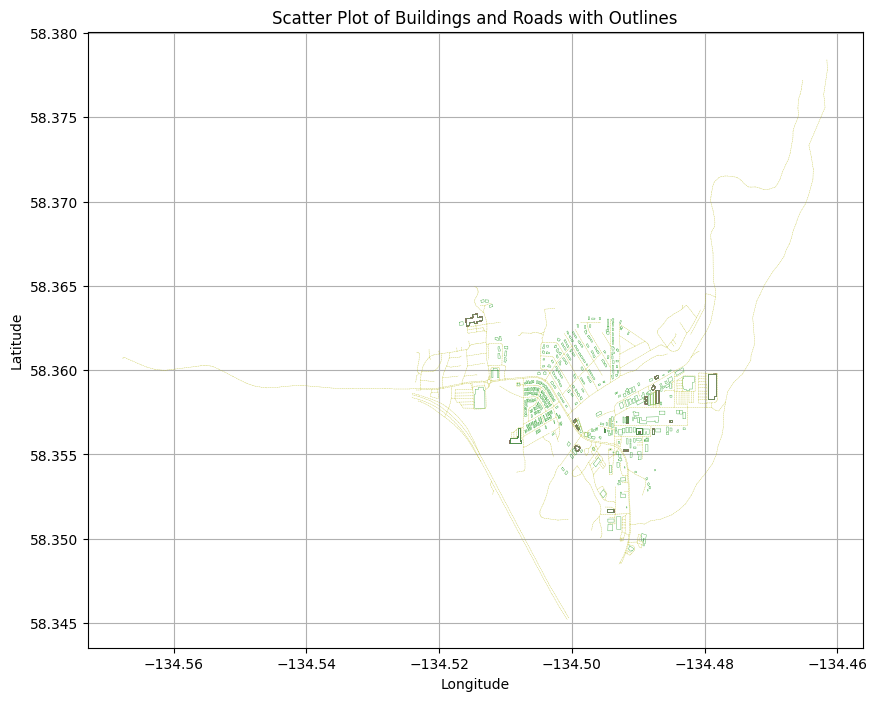

In [62]:
plot_scatter_graph(
    seq(building_by_type.items()).map(lambda b: b[1]).list(),
    graph,
    # points_of_interest=seq(locations_by_type.items())
    #     .map(lambda x: x[1])
    #     .flatten()
    #     .list()
)

In [63]:
from copy import deepcopy

def add_buildings_to_graph(buildings: List[Building], G: nx.Graph):
    """
    Creates a clone of the graph, then adds buildings to the cloned graph by connecting their centroids 
    to the nearest intersection node (a node that existed in the original graph).

    Args:
        buildings: List of Building objects.
        G: NetworkX graph containing nodes with lat and lon attributes.

    Returns:
        A new cloned graph with the buildings and centroid connections added.
    """
    # Clone the graph to avoid modifying the original
    G_cloned = deepcopy(G)

    # Get the list of intersection nodes (nodes that existed before adding buildings)
    original_nodes = set(G_cloned.nodes)

    for building in buildings:
        # Calculate the building's centroid
        try:
            centroid_lon, centroid_lat = building.get_centroid()
        except:
            continue

        # Find the nearest intersection node to the centroid
        nearest_node_id = None
        min_distance = float('inf')

        for node_id in original_nodes:
            data = G_cloned.nodes[node_id]
            node_lon, node_lat = data['lon'], data['lat']
            distance = ((centroid_lon - node_lon) ** 2 + (centroid_lat - node_lat) ** 2) ** 0.5
            if distance < min_distance:
                min_distance = distance
                nearest_node_id = node_id

        # Add the centroid as a new node in the cloned graph
        centroid_node_id = building.id
        G_cloned.add_node(centroid_node_id, lat=centroid_lat, lon=centroid_lon)

        # Connect the centroid to the nearest intersection node
        if nearest_node_id is not None:
            G_cloned.add_edge(centroid_node_id, nearest_node_id)

    return G_cloned

In [64]:
new_graph = add_buildings_to_graph(
    seq(building_by_type.items()).map(lambda b: b[1]).flatten().list(),
    graph,
)

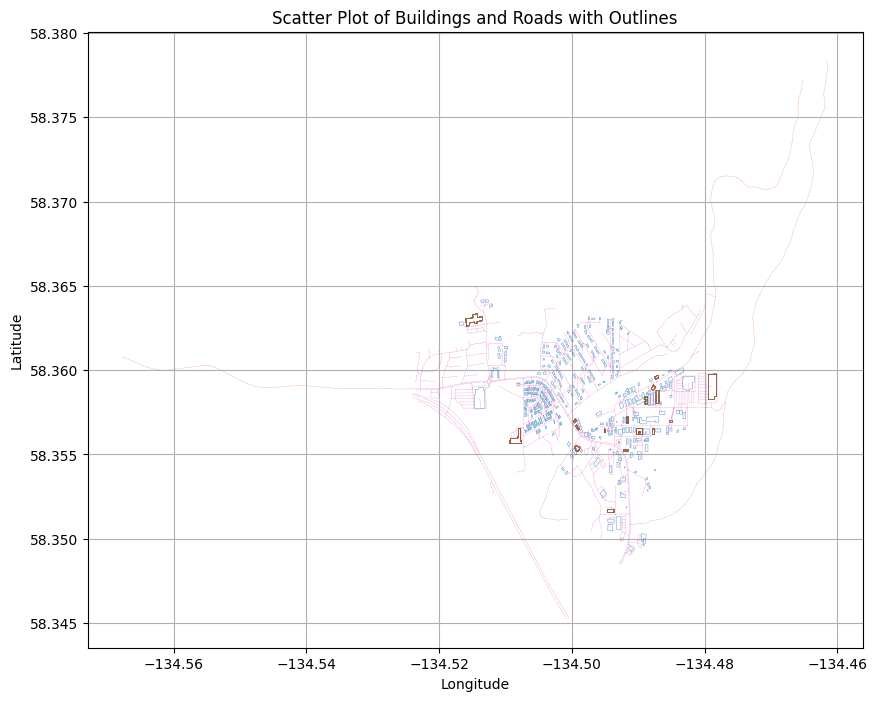

In [65]:
plot_scatter_graph(
    seq(building_by_type.items()).map(lambda b: b[1]).list(),
    new_graph,
    # points_of_interest=seq(locations_by_type.items())
    #     .map(lambda x: x[1])
    #     .flatten()
    #     .list()
)

In [66]:
from dataclasses import asdict
import json
def export_to_json(graph: nx.Graph, nodes: List[Node], buildings: Dict[str, List[Building]], file_path: str) -> None:
    # print(nodes)

    nodes_data = (seq(nodes.items()).map(lambda x: (x[0], asdict(x[1]))).dict())
    # print(nodes_data)
    data = {
        "graph": nx.node_link_data(graph),  # Converts the graph to a JSON-serializable format
        "nodes": nodes_data,
        "buildings": {
            key: [asdict(building) for building in building_list]
            for key, building_list in buildings.items()
        }
    }

    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)

In [67]:
export_to_json(new_graph, nodes, building_by_type, "data.json")